In [6]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import time
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from IPython.display import Image  
pd.options.mode.chained_assignment = None #'warn'
import warnings
warnings.filterwarnings("ignore")

In [7]:
default_seed = 2020
data = pd.read_csv(r"/home/acts2/proj_traffic/resample.csv")
X_train = data.drop('Accident_Severity',axis=1)
y_train = data['Accident_Severity']
data1 = pd.read_csv(r"/home/acts2/proj_traffic/test.csv")
X_test = data1.drop('Accident_Severity',axis=1)
y_test = data1['Accident_Severity']
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


out = {'X_train':X_train, 'y_train':y_train,  'X_test':X_test, 'y_test':y_test}

In [8]:
def fit_classification(model, data_dict,cv_parameters = {},model_name = None,random_state = 2020):
   
    np.random.seed(random_state)
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']    
    cv_model = GridSearchCV(model, cv_parameters,scoring='roc_auc')
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    best_model = cv_model.best_estimator_
    if model_name != None:
        print("=========================================================")
        print("  Model: " + model_name)
        print("=========================================================")

    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Optimal parameters:")
    print(cv_model.best_params_)
    print(" Best Score:")
    print(cv_model.best_score_)
    print("")
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        probs_predicted = True
    except:
        probs_predicted = False
    y_pred = best_model.predict(X_test)
    
    
    print("Accuracy on test dataset: ", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))
    
    
    if probs_predicted:        
        plt.figure(figsize = (13, 4.5))
        plt.subplot(2, 2, 1)

        plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
        plt.plot(fpr, tpr, 'b')
        plt.plot([0,1],[0,1],'r--')
        plt.xlim([0,1]); plt.ylim([0,1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        plt.savefig(model_name+".png")

    out = {'model':best_model, 'roc_auc_score':roc_auc_score(y_test, y_pred_probs), 'accuracy_score': cv_model.best_score_,'accuracy_score_test':accuracy_score(y_test, y_pred), 'y_pred': y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
               
    return out






Running logistic
  Model: l2 Penalized Logistic Regression
Fit time: 1033.77 seconds
Optimal parameters:
{'C': 21.54434690031882}
 Best Score:
0.7016961108585259

Accuracy on test dataset:  0.6409444948578342
              precision    recall  f1-score   support

  No default     0.9121    0.6413    0.7531    451651
     Default     0.2337    0.6389    0.3422     77309

    accuracy                         0.6409    528960
   macro avg     0.5729    0.6401    0.5476    528960
weighted avg     0.8129    0.6409    0.6930    528960



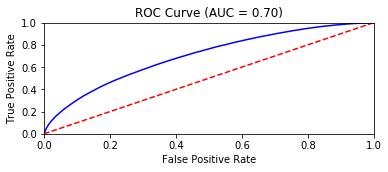

<Figure size 432x288 with 0 Axes>

In [4]:
print('Running logistic')
l2_logistic = LogisticRegression(penalty = 'l2')
cv_parameters = {"C":np.logspace(-4, 4, num = 10)}

l2_logistic_bal = fit_classification(l2_logistic, out, cv_parameters = cv_parameters, model_name = "l2 Penalized Logistic Regression")
pickle.dump([out,l2_logistic_bal], open("logistic.pickle", "wb") )

In [ ]:
print("xgb")
lr_range=[0.001, 0.01, 0.1]
n_est_range=[20,30,50,100]
md_range=[2,4,6,8,10]
parameters=dict(learning_rate=lr_range, n_estimators=n_est_range, max_depth=md_range)
clf_bal=XGBClassifier()
clf_bal = fit_classification(clf_bal, out, cv_parameters = parameters, model_name="XGB Classifier")
pickle.dump([out,clf_bal], open("clf_bal.pickle", "wb") )


print("Random_Forest")
random_forest=RandomForestClassifier()
cv_params={'min_samples_leaf':[10,20,30,40],'n_estimators':[100,150,250]}
random_forest_bal = fit_classification(random_forest,out,cv_parameters=cv_params,model_name="Random Forest")
pickle.dump([out,random_forest_bal], open("random_forest_bal.pickle", "wb") )


print("mlp !!")
mlp_bal = MLPClassifier()
cv_parameters = {'hidden_layer_sizes':[(1), (10), (50), (100), (5, 5), (10, 10)]}

mlp_bal = fit_classification(mlp_bal, out,cv_parameters = cv_parameters, model_name="Multi-Layer Perceptron")
pickle.dump([out,mlp_bal], open("mlp_bal.pickle", "wb") )



print("decision tree")
decision_tree_bal = DecisionTreeClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}
decision_tree_bal = fit_classification(decision_tree_bal, out,cv_parameters = cv_parameters, model_name = "Decision tree")
pickle.dump([out,decision_tree_bal], open("decision_tree_bal.pickle", "wb") )

xgb
